In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Noto Sans CJK JP')
matplotlib.style.use('dark_background')
import random
# from define_property import define_properties

# import typing as tp
from typing import List, Dict, Tuple, Optional, Union, Any
# from typing import TypeVar, Generic
from nptyping import NDArray, Float

import logging

formatter = "[%(levelname)-6s] %(message)s"
logging.basicConfig(level=logging.INFO, format=formatter)

import sys

# print(sys.path)
# print(sys.version_info)

In [2]:
# @title define_property
import sys
import logging


def define_property(self, name, value=None, readable=True, writable=True):
    # "_User__name" のような name mangling 後の名前.
    field_name = "_{}__{}".format(self.__class__.__name__, name)

    # 初期値を設定する.
    setattr(self, field_name, value)

    # getter/setter を生成し, プロパティを定義する.
    getter = (lambda self: getattr(self, field_name)) if readable else None
    setter = (
        (lambda self, value: setattr(self, field_name, value)) if writable else None
    )
    setattr(self.__class__, name, property(getter, setter))


def define_properties(constructor=None, *, accessible=(), readable=(), writable=()):
    if callable(constructor):

        def wrapper(self, *args, **kwargs):
            for name, value in kwargs.items():
                logging.debug(
                    "{}.{}: {}: {}".format(
                        self.__class__.__name__,
                        sys._getframe().f_code.co_name,
                        name,
                        value,
                    )
                )
                define_property(self, name, value)
            constructor(self, *args, **kwargs)

        return wrapper
    else:
        to_set = (
            lambda x: set(x)
            if any(isinstance(x, type_) for type_ in (set, list, tuple))
            else {x}
        )
        accessibles = to_set(accessible)
        readables = accessibles | to_set(readable)
        writables = accessibles | to_set(writable)

        def decorator(constructor):
            def wrapper(self, *args, **kwargs):
                for name in readables | writables:
                    readable = name in readables
                    writable = name in writables
                    initial_value = kwargs.get(name, None)
                    logging.debug(
                        "{}.{}: {}: {}".format(
                            self.__class__.__name__,
                            sys._getframe().f_code.co_name,
                            name,
                            initial_value,
                        )
                    )
                    define_property(self, name, initial_value, readable, writable)
                constructor_kwargs = dict(
                    [
                        (key, kwargs[key])
                        for key in (constructor.__kwdefaults__ or {})
                        if key in kwargs
                    ]
                )
                constructor(self, *args, **constructor_kwargs)

            return wrapper

        return decorator

## 初期値

In [3]:
# チャンネル数, Txアンテナ数
Nch: int = 4
# Rxアンテナ数
NchRx: int = 3

## Object Base Class

In [4]:
class RadarObject:
    """
    Rader Object
    Rader Object の初期座標、加速度等の値を保持するクラス

    Attributes
    ----------
    x: float 
        initial location x
    y: float
        initial location y
    accl_x: float
        acceleration vector x
    accl_y: float
        acceleration vector y
    """

    x: float
    y: float
    accl_x: float
    accl_y: float

    @define_properties(readable=("x", "y", "accl_x", "accl_y"))
    def __init__(self) -> None:
        pass

    @property
    def loc(self) -> Tuple[float, float]:
        return self.x, self.y

    @property
    def loc_x(self) -> float:
        return self.x

    @property
    def loc_y(self) -> float:
        return self.y

    def output(self) -> None:
        print(
            "{}.{}: ({},{}),({},{})".format(
                self.__class__.__name__,
                sys._getframe().f_code.co_name,
                self.x,
                self.y,
                self.accl_x,
                self.accl_y,
            )
        )


class RadarObjectGroup:
    """
    Rader Object Group
    各Radar Objectの要素を纏めたアクセスを提供するクラス
    
    Attributes
    ----------
    list: List[RadarObject] 
        Rader Object Group の リスト
    """

    list: List[RadarObject] = []

    @define_properties(readable="list")
    def __init__(self) -> None:
        pass

    @property
    def loc(self) -> List[Tuple[float, float]]:
        return [i.loc for i in self.list]

    @property
    def loc_x(self) -> List[float]:
        return [i.loc_x for i in self.list]

    @property
    def loc_y(self) -> List[float]:
        return [i.loc_y for i in self.list]

    def output(self) -> None:
        for i in self.list:
            i.output()

## Target Object Class

In [5]:
class Target(RadarObject):
    """
    物標

    Attributes
    ----------
    x: float 
        initial location x
    y: float
        initial location y
    accl_x: float
        acceleration vector x
    accl_y: float
        acceleration vector y
    """
    pass


class TargetGroup(RadarObjectGroup):
    """
    物標群
    list: list of target object group
    """
    pass

## Antenna Object Class

In [6]:
class Antenna(RadarObject):
    """
    アンテナ

    Attributes
    ----------
    x: float 
        initial location x
    y: float
        initial location y
    """

    def output(self) -> None:
        print(
            "{}.{}: ({},{})".format(
                self.__class__.__name__, sys._getframe().f_code.co_name, self.x, self.y,
            )
        )


class AntennaGroup(RadarObjectGroup):
    """
    アレイ・アンテナ
    list: list of Antenna object group
    """

    pass

In [7]:
### Object Test
a = Antenna(x=10, y=20)
b = Antenna(x=30, y=40)
a.output()
print(a.loc)
b.output()
print(b.loc)
print(b.loc_x)
print(b.loc_y)
c = AntennaGroup(list=[a, b])
print(c.loc)
print(c.loc_x)
print(c.loc_y)
c.output()

Antenna.output: (10,20)
(10, 20)
Antenna.output: (30,40)
(30, 40)
30
40
[(10, 20), (30, 40)]
[10, 30]
[20, 40]
Antenna.output: (10,20)
Antenna.output: (30,40)


## 物標およびアンテナ

In [8]:
class ObjectLocation:
    """
    ObjectLocation
    
    物標およびアンテナの位置関係を管理

    Attributes
    ----------
    TX: AntennaGroup 
        Transmission Antenna Group Object
    RX: AntennaGroup
        Receiving Antenna Group Object
    TGT: TargetGroup
        Target Group Object
    cur_time: float
        Current time
    """

    TX: AntennaGroup
    RX: AntennaGroup
    TGT: TargetGroup

    @define_properties(readable=("TX", "RX", "TGT"))
    def __init__(self, *, cur_time: float = 0.0) -> None:
        define_property(self, "cur_time", cur_time)
        # pass

    @property
    def distance(self) -> NDArray[(Any, Any, Any), Float[64]]:
        """
        Txアンテナ〜物標〜Rxアンテナ距離
        
        Returns
        -------
        res: NDArray[(Any, Any, Any), Float[64]]
            Txアンテナ〜物標〜Rxアンテナの距離
            res[RX, TGT, TX]
        """
        # Txアンテナ〜物標距離
        dist_tx_tgt = self.__get_distance(src=TX.loc, dest=TGT.loc)
        # 物標〜Rxアンテナ距離
        dist_tgt_rx = self.__get_distance(src=TGT.loc, dest=RX.loc)
        # print("dist_tx_tgt = ", dist_tx_tgt.shape, dist_tx_tgt)
        # print("dist_tgt_rx = ", dist_tgt_rx.shape, dist_tgt_rx)

        [idxRx, idxTgt, idxTx] = np.unravel_index(
            np.array(range(len(RX.loc) * len(TGT.loc) * len(TX.loc))),
            (len(RX.loc), len(TGT.loc), len(TX.loc)),
        )
        # print("idxTx = ", idxTx)
        # print("idxTgt = ", idxTgt)
        # print("idxRx = ", idxRx)

        res = np.reshape(
            np.array(
                [
                    (
                        dist_tx_tgt[idxTx[idx], idxTgt[idx]]
                        + dist_tgt_rx[idxTgt[idx], idxRx[idx]]
                    )
                    for idx in range(len(idxTx))
                ]
            ),
            [len(TGT.loc), len(RX.loc), len(TX.loc)],
        )
        # print("res = ", res.shape, res)
        return res

    def graph(self) -> None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(self.TX.loc_x, self.TX.loc_y, c="green", label="TX")
        ax.scatter(self.RX.loc_x, self.RX.loc_y, c="blue", label="RX")
        ax.scatter(self.TGT.loc_x, self.TGT.loc_y, c="orange", label="TGT")
        ax.set_title("Object position")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend(loc="lower right")
        fig.show()

    def output(self) -> None:
        for obj in ["TX", "RX", "TGT"]:
            print(
                "{}.{}: {:3s}: {}".format(
                    self.__class__.__name__,
                    sys._getframe().f_code.co_name,
                    obj,
                    eval("self.{}.loc".format(obj)),
                )
            )

    def __get_distance(
        self, src: List[Tuple[float, float]], dest: List[Tuple[float, float]]
    ) -> NDArray[(Any, Any), Float[64]]:
        """
        Radar Object 間の距離を計算する

        Parameters
        ----------
        src: List[Tuple[float, float]]
            始点群
        dest: List[Tuple[float, float]]
            終点群

        Returns
        -------
        res: NDArray[(Any, Any), Float[64]]
            Radar Object 間の距離
            res[始点(src), 終点(dest)]
        """
        [i, j] = np.unravel_index(
            np.array(range(len(src) * len(dest))), (len(src), len(dest))
        )
        s = np.array([src[k] for k in i])
        d = np.array([dest[k] for k in j])
        res = np.reshape(np.sqrt(np.sum((s - d) ** 2, axis=1)), [len(src), len(dest)])
        return res

ObjectLocation.output: TX : [(0.0, 4.0), (0.6666666666666666, 8.0), (1.3333333333333333, 12.0), (2.0, 16.0)]
ObjectLocation.output: RX : [(10.0, 0.0), (11.0, -1.0), (12.0, -2.0)]
ObjectLocation.output: TGT: [(99, 10), (100, 8)]
0.0
1.0


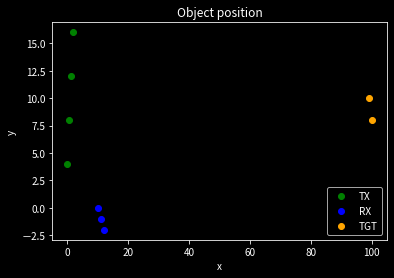

In [9]:
## Initial Position
TX = AntennaGroup(
    list=[
        Antenna(x=x, y=y)
        for x, y in zip(np.linspace(0, 2, Nch), np.linspace(4.0, 16.0, Nch))
    ]
)
RX = AntennaGroup(
    list=[
        Antenna(x=x, y=y)
        for x, y in zip(np.linspace(10.0, 12.0, NchRx), np.linspace(0, -2.0, NchRx))
    ]
)
TGT = TargetGroup(
    list=[
        Target(x=x, y=y, accl_x=ax, accl_y=ay)
        for x, y, ax, ay in [(99, 10, 10, 10), (100, 8, 10, 10)]
    ]
)
# TX.output()
# RX.output()
# TGT.output()
ol = ObjectLocation(TX=TX, RX=RX, TGT=TGT)
ol.output()
ol.graph()
ol.distance
print(ol.cur_time)
ol.cur_time = 1.0
print(ol.cur_time)

In [10]:
from nptyping import NDArray

NDArray[(3,), np.int8]

NDArray[(3,), Int[8]]

In [11]:
# import dataclasses
from pydantic.dataclasses import dataclass


@dataclass
class RadarItem:
    """Class for keeping track of an item of radar."""

    # 送受信データビット数 QPSK is 2bit(00,01,10,11)
    NumBits: int = 2
    # サブキャリア
    Nc: int = 1024
    #     # vector from 0 to Nc-1
    #     vecNc: NDArray[(1024), int] = np.array(range(math.floor((Nc - 1) / Nch)))
    # 光速度
    c0: float = 299792458
    # 吸収率
    absorptivity: float = 0.5
    # OFDM symbol width
    T: float = 11e-6
    # OFDM cyclic prefix width
    Tp: float = 1.375e-6
    # Carrier interval 90.909kHz subcarrier grid
    deltaF: float = 1 / T
    # ADC Sampling frequency
    Tsmp: float = T / Nc
    # 最大検知可能距離 (m)
    Rmax: float = c0 * Tp / 2
    # distance resolution
    Rres = Rmax / (Nc / (T / Tp))

In [12]:
ri = RadarItem()
print(ri)

RadarItem(NumBits=2, Nc=1024, c0=299792458.0, absorptivity=0.5, T=1.1e-05, Tp=1.375e-06, deltaF=90909.09090909091, Tsmp=1.07421875e-08, Rmax=206.107314875)


In [13]:
class RaderWave:
    """
    RaderWave
    
    レーダー波の管理

    Attributes
    ----------
    data: NDArray[(Any), Int]
        送信波シンボルデータ
    item: RadarItem
        レーダー波定数等
    """

    data: NDArray[(Any), np.int32]
    item: RadarItem

    @define_properties(readable=("data", "item"))
    def __init__(self) -> None:
        pass

    @property
    def TX_wave(self) -> NDArray[(Any, Any), np.complex128]:
        """
        位相変換 PSK(Phase Shift keying)

        $$\begin{array}{l}N_{\textrm{sym}} =1\;\left(1\textrm{frame}\right)\\x\left(t\right)=\sum_{\mu 
=0}^{N_{\textrm{sym}} -1} \sum_{n=0}^{N_c -1} d_{\textrm{Tx}} \left(\mu N_c 
+n\right)\exp \left(\textrm{j2}\pi {\mathit{\mathbf{f}}}_{\mathit{\mathbf{n}}} 
\mathit{\mathbf{t}}\right)\textrm{rect}\left(\frac{t-\mu T}{T}\right)\end{array}$$

        OPSK constellation part の式は $d_{\textrm{Tx}} \left(\mu N_c +n\right)$
       
        Returns
        -------
        res: NDArray[(Any, Any), np.complex128]:
            送信波(fft前)
        """
        M = 2 ** self.item.NumBits
        m = np.arange(0, M)
        phi = np.pi / 4
        constellation = np.exp(1j * 2 * np.pi * m / M + 1j * phi)
        # print(constellation)
        # サブキャリア数分の1埋めベクターとアンテナ数分の単位行列のクロネッカー積を取ることでサブチャンネルにアンテナ毎のデータを割り当てる
        UM = np.kron(np.ones(np.int(np.ceil((self.item.Nc / Nch)))), np.eye(Nch))
        # アンテナ数で生成した単位行列をframe数分連結
        UM = UM[:, : self.item.Nc]
        # print(UM)
        # OFDM変調 part の式は exp(j2𝜋𝑓𝑛𝑡)
        TXDataQPSK = np.array([constellation[i] for i in self.data])
        # print("TXDataQPSK=", TXDataQPSK.shape, TXDataQPSK)
        # サブチャンネル毎のデータ割り当て
        res = UM * TXDataQPSK
        return res

    @property
    def ideal_TX_wave(self) -> NDArray[(Any, Any), np.complex128]:
        """
        位相変換 PSK(Phase Shift keying)

        $$\begin{array}{l}N_{\textrm{sym}} =1\;\left(1\textrm{frame}\right)\\x\left(t\right)=\sum_{\mu 
=0}^{N_{\textrm{sym}} -1} \sum_{n=0}^{N_c -1} d_{\textrm{Tx}} \left(\mu N_c 
+n\right)\exp \left(\textrm{j2}\pi {\mathit{\mathbf{f}}}_{\mathit{\mathbf{n}}} 
\mathit{\mathbf{t}}\right)\textrm{rect}\left(\frac{t-\mu T}{T}\right)\end{array}$$

        OPSK constellation part の式は $d_{\textrm{Tx}} \left(\mu N_c +n\right)$
       
        Returns
        -------
        res: NDArray[(Any, Any), np.complex128]:
            送信波
        """
        return np.fft.ifft(self.TX_wave)

送信ランダム データ シンボルを生成

In [14]:
TXData = np.random.randint(0, 2 ** ri.NumBits, ri.Nc)
# TXData = zeros(Nc,1);
print(TXData)

rw = RaderWave(data=TXData, item=ri)
print(rw.data)
print(rw.item)
# TX = rw.TX_wave
ideal_TX = rw.ideal_TX_wave
print("ideal_TX=", ideal_TX.shape, ideal_TX)
TX.loc

[3 2 2 ... 3 2 2]
[3 2 2 ... 3 2 2]
RadarItem(NumBits=2, Nc=1024, c0=299792458.0, absorptivity=0.5, T=1.1e-05, Tp=1.375e-06, deltaF=90909.09090909091, Tsmp=1.07421875e-08, Rmax=206.107314875)
ideal_TX= (4, 1024) [[ 0.00966748+0.00138107j  0.00476648-0.01305788j  0.01121939-0.01774362j
  ...  0.00891018+0.01487287j -0.01544753+0.00565708j
   0.01426982+0.00428539j]
 [-0.00966748-0.01104854j  0.00628203-0.00163745j  0.00471611-0.02359841j
  ...  0.00836557+0.00131911j -0.00090239-0.00102918j
  -0.00751093+0.00059661j]
 [-0.01381068+0.01242961j  0.00096394-0.0121419j  -0.00592754-0.00663397j
  ... -0.02163978-0.01356013j -0.0063366 -0.00252501j
  -0.00110985+0.00825897j]
 [ 0.02485922+0.00552427j  0.01648347-0.00669467j  0.00056525+0.01243253j
  ...  0.00620918-0.01100756j  0.0159783 +0.00066921j
  -0.01064434+0.00442785j]]


[(0.0, 4.0),
 (0.6666666666666666, 8.0),
 (1.3333333333333333, 12.0),
 (2.0, 16.0)]